In [6]:
import xarray as xr
import numpy as np
import xesmf as xe
import os


gridFile="/Users/james/Documents/Github/esm_lab/gridTools/nep7_grid/ocean_hgrid.nc"
#gridFile = "/Users/james/Downloads/gridFile.nc"
topoFile="/Users/james/Downloads/GEBCO_2020.nc"
gridGeoLoc = "corner"
topoVarName = 'elevation'
periodic=True
method='conservative'
gridLatName = None
gridLonName = None
topoLatName = None
topoLonName = None
topoDimX = None
topoDimY = None
coarsenInt = 2
grid = xr.open_dataset(gridFile)
gridGeoLoc = 'corner'

if gridGeoLoc == "center":
    if 'nx' not in grid.dims:
        if gridDimX != None:
            grid = grid.rename_dims({gridDimX : "nx"})
        elif 'lon' in grid.dims:
            grid = grid.rename_dims({"lon" : "nx"})
        elif 'longitude' in grid.dims:
            grid = grid.rename_dims({"longitude" : "nx"})
        elif 'x' in grid.dims:
            grid = grid.rename_dims({"x" : "nx"})
        else:
            print ('Error: plase define gridDimX')
    if 'ny' not in grid.dims:
        if gridDimX != None:
            grid = grid.rename_dims({gridDimY : "ny"})
        elif 'lon' in grid.dims:
            grid = grid.rename_dims({"lat" : "ny"})
        elif 'longitude' in grid.dims:
            grid = grid.rename_dims({"latitude" : "ny"})
        elif 'y' in grid.dims:
            grid = grid.rename_dims({"y" : "ny"})
        else:
            print ('Error: plase define gridDimY')
    
    if 'lat_centers' not in grid.variables:
        if gridLatName != None:
            grid = grid.rename({gridLatName: 'lat_centers'})
        elif 'y' in grid.variables:
            grid = grid.rename({'y': 'lat_centers'})
        elif 'lat' in grid.variables:
            grid = grid.rename({'lat': 'lat_centers'})
        elif 'latitude' in grid.variables:
            grid = grid.rename({'latitude': 'lat_centers'})
        else:
            print('Error: please define gridlatname')
    
            
    if 'lon_centers' not in grid.variables:
        if gridLonName != None:
            grid = grid.rename({gridLonName : 'lon_centers'})
        elif 'x' in grid.variables:
            grid = grid.rename({'x': 'lon_centers'})
        elif 'lon' in grid.variables:
            grid = grid.rename({'lon': 'lon_centers'})
        elif 'longitude' in grid.variables:
            grid= grid.rename({'longitude': 'lon_centers'})
        else:
            print('Error: Please define gridLonName')
    
    # fix longitude from -180 to 180
    if "lon_corners" in grid.coords:
        grid = grid.assign_coords(lon_corners=(np.where(grid['lon_corners'].values > 180., grid['lon_corners'].values - 360, 
                                                        grid['lon_corners'].values)))
        grid = grid.swap_dims({'lon_corners' : 'nxp'})    
    if "lon_corners" in grid.data_vars:
        grid['lon_corners'].values =  np.where(grid['lon_corners'].values > 180., grid['lon_corners'].values - 360, 
                                               grid['lon_corners'].values)

    lon_centers = grid['lon_centers'].values
    lat_centers = grid['lat_centers'].values
    
    # To use conservative regidding, we need the cells corners. 
    # Since they are not provided, we are creating some using a crude approximation. 
    lon_corners = 0.25 * (
        lon_centers[:-1, :-1]
        + lon_centers[1:, :-1]
        + lon_centers[:-1, 1:]
        + lon_centers[1:, 1:]
    )
    
    # trying to expand out the cornesr here by taking the difference of the last row/column, 
    # adding the difference to the last row/column, then plugging that new row/column into an expanded matrix called filler_array
    filler_array = np.zeros((lon_corners.shape[0] + 1, lon_corners.shape[1] + 1))
    filler_array[0:lon_corners.shape[0], 0:lon_corners.shape[1]] = lon_corners[:,:]
    extCol = np.append(np.diff(lon_corners[:,-1]), np.diff(lon_corners[:,-1])[-1])  + lon_corners[:,-1]
    extRow = np.append(np.diff(lon_corners[-1,:], axis=0), np.diff(lon_corners[-1,:], axis=0)[-1])  + lon_corners[-1,:]
    filler_array[0:extCol.shape[0], -1] = extCol
    filler_array[-1, 0:extRow.shape[0]] = extRow
    # there is one final corner that's not been interpolated, fill that cell here - have to double the difference to avoid repeating 
    # the same value for that final corner
    final_corner = np.diff(lon_corners[-1,:])[-1]*2  + lon_corners[-1,-1]
    filler_array[-1,-1] = final_corner
    # testing
    # plt.pcolormesh(filler_array)
    grid['lon_corners'] = xr.DataArray(data=filler_array, dims=("nyp", "nxp"))
    
    lat_corners = 0.25 * (
        lat_centers[:-1, :-1]
        + lat_centers[1:, :-1]
        + lat_centers[:-1, 1:]
        + lat_centers[1:, 1:]
    )
    
    
    # trying to expand out the cornesr here by taking the difference of the last row/column, 
    # adding the difference to the last row/column, then plugging that new row/column into an expanded matrix called filler_array
    filler_array = np.zeros((lat_corners.shape[0] + 1, lat_corners.shape[1] + 1))
    filler_array[0:lat_corners.shape[0], 0:lat_corners.shape[1]] = lat_corners[:,:]
    extCol = np.append(np.diff(lat_corners[:,-1]), np.diff(lat_corners[:,-1])[-1])  + lat_corners[:,-1]
    extRow = np.append(np.diff(lat_corners[-1,:], axis=0), np.diff(lat_corners[-1,:], axis=0)[-1])  + lat_corners[-1,:]
    filler_array[0:extCol.shape[0], -1] = extCol
    filler_array[-1, 0:extRow.shape[0]] = extRow
    # there is one final corner that's not been interpolated, fill that cell here - have to double the difference to avoid repeating 
    # the same value for that final corner
    final_corner = np.diff(lat_corners[-1,:])[-1]*2  + lat_corners[-1,-1]
    filler_array[-1,-1] = final_corner
    # testing
    #plt.pcolormesh(filler_array)
    # add formal lat corner to grid object
    grid['lat_corners'] = xr.DataArray(data=filler_array, dims=("nyp", "nxp"))
    
if gridGeoLoc == "corner":
    # organize dimensions to nx ny nxp nyp
    if 'nxp' not in grid.dims:
        if gridDimX != None:
            grid = grid.rename_dims({gridDimX : "nxp"})
        elif 'lon' in grid.dims:
            grid = grid.rename_dims({"lon" : "nxp"})
        elif 'longitude' in grid.dims:
            grid = grid.rename_dims({"longitude" : "nxp"})
        elif 'x' in grid.dims:
            grid = grid.rename_dims({"x" : "nxp"})
        else:
            print ('Error: plase define gridDimX')
    if 'nyp' not in grid.dims:
        if gridDimX != None:
            grid = grid.rename_dims({gridDimY : "nyp"})
        elif 'lon' in grid.dims:
            grid = grid.rename_dims({"lat" : "nyp"})
        elif 'longitude' in grid.dims:
            grid = grid.rename_dims({"latitude" : "nyp"})
        elif 'y' in grid.dims:
            grid = grid.rename_dims({"y" : "nyp"})
        else:
            print ('Error: plase define gridDimY')
            
    if 'lat_corners' not in grid.variables:
        if gridLatName != None:
            grid = grid.rename({gridLatName: 'lat_corners'})
        elif 'y' in grid.variables:
            grid = grid.rename({'y': 'lat_corners'})
        elif 'lat' in grid.variables:
            grid = grid.rename({'lat': 'lat_corners'})
        elif 'latitude' in grid.variables:
            grid = grid.rename({'latitude': 'lat_corners'})
        else:
            print('Error: please define gridlatname')
    
            
    if 'lon_corners' not in grid.variables:
        if gridLonName != None:
            grid = grid.rename({gridLonName : 'lon_corners'})
        elif 'x' in grid.variables:
            grid = grid.rename({'x': 'lon_corners'})
        elif 'lon' in grid.variables:
            grid = grid.rename({'lon': 'lon_corners'})
        elif 'longitude' in grid.variables:
            grid= grid.rename({'longitude': 'lon_corners'})
        else:
            print('Error: Please define gridLonName')

    # fix longitude from -180 to 180
    if "lon_corners" in grid.coords:
        grid = grid.assign_coords(lon_corners=(np.where(grid['lon_corners'].values > 180., grid['lon_corners'].values - 360, 
                                                        grid['lon_corners'].values)))
        grid = grid.swap_dims({'lon_corners' : 'nxp'})    
    if "lon_corners" in grid.data_vars:
        grid['lon_corners'].values =  np.where(grid['lon_corners'].values > 180., grid['lon_corners'].values - 360, 
                                               grid['lon_corners'].values)

    lon_corners = grid['lon_corners'].values
    lat_corners = grid['lat_corners'].values
    
    # To use conservative regidding, we need the cells centers. 
    # Since they are not provided, we are creating some using a crude approximation. 
    lon_centers = 0.25 * (
        lon_corners[:-1, :-1]
        + lon_corners[1:, :-1]
        + lon_corners[:-1, 1:]
        + lon_corners[1:, 1:]
    )
    
    lat_centers = 0.25 * (
        lat_corners[:-1, :-1]
        + lat_corners[1:, :-1]
        + lat_corners[:-1, 1:]
        + lat_corners[1:, 1:]
    )
    
    grid['lat_centers'] = xr.DataArray(data=lat_centers, dims=("ny", "nx"))
    grid['lon_centers'] = xr.DataArray(data=lon_centers, dims=("ny", "nx"))
    

    

In [7]:
# TOPOGRAPHY XARRAY OBJECT ORGANIZATION
topo = xr.open_dataset(topoFile)

if 'nx' not in topo.dims:
    if topoDimX != None:
        topo = topo.rename_dims({topoDimX : "nx"})
    elif 'lon' in topo.dims:
        topo = topo.rename_dims({"lon" : "nx"})
    elif 'longitude' in topo.dims:
        topo = topo.rename_dims({"longitude" : "nx"})
    elif 'x' in topo.dims:
        topo = topo.rename_dims({"x" : "nx"})
    else:
        print ('Error: plase define topoDimX')
if 'ny' not in topo.dims:
    if topoDimY != None:
        topo = topo.rename_dims({topoDimY : "ny"})
    elif 'lat' in topo.dims:
        topo = topo.rename_dims({"lat" : "ny"})
    elif 'latitude' in topo.dims:
        topo = topo.rename_dims({"latitude" : "ny"})
    elif 'y' in topo.dims:
        topo = topo.rename_dims({"y" : "ny"})
    else:
        print ('Error: plase define topoDimY')
        
# coarsen topo file down based on coarsenInt
topo = topo.coarsen(nx=coarsenInt,ny=coarsenInt, boundary='pad').median()

if 'lat_centers' not in topo.variables:
    if topoLatName != None:
        topo = topo.rename({topoLatName: 'lat_centers'})
    elif 'y' in topo.variables:
        topo = topo.rename({'y': 'lat_centers'})
    elif 'lat' in topo.variables:
        topo = topo.rename({'lat': 'lat_centers'})
    elif 'latitude' in topo.variables:
        topo = topo.rename({'latitude': 'lat_centers'})
    else:
        print('Error: please define gridlatname')
if 'lon_centers' not in topo.variables:
    if topoLonName != None:
        topo = topo.rename({topoLonName : 'lon_centers'})
    elif 'x' in topo.variables:
        topo = topo.rename({'x': 'lon_centers'})
    elif 'lon' in topo.variables:
        topo = topo.rename({'lon': 'lon_centers'})
    elif 'longitude' in grid.variables:
        topo = topo.rename({'longitude': 'lon_centers'})
    else:
        print('Error: Please define gridLonName')


# grab index location of grid extents
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# if longitudes are 0 to 360, convert to -180 to 180
if "lon_centers" in topo.coords:
    topo = topo.assign_coords(lon_centers=(np.where(topo['lon_centers'].values > 180., topo['lon_centers'].values - 360, 
                                                    topo['lon_centers'].values)))
    topo = topo.swap_dims({'lon_centers' : 'nx'})
if "lon_centers" in topo.data_vars:
    topo['lon_centers'].values =  np.where(topo['lon_centers'].values > 180., topo['lon_centers'].values - 360, topo['lon_centers'].values)


In [8]:
topo2 = topo

In [10]:
topo_backup = topo

In [12]:
len(topo2.lon_centers.values)

43200

In [26]:
expLonCenters = np.zeros(len(topo2.lon_centers.values) + 6)
expLonCenters[0], expLonCenters[1],expLonCenters[2], expLonCenters[-1], expLonCenters[-2],  expLonCenters[-3] = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
expLonCenters[3:-3] = topo2.lon_centers.values
expLonCenters[0] = expLonCenters[3] - 3*(np.diff(expLonCenters[3:5]))
expLonCenters[1] = expLonCenters[3] - 2*(np.diff(expLonCenters[3:5]))
expLonCenters[2] = expLonCenters[3] - 1*(np.diff(expLonCenters[3:5]))
expLonCenters[-1] = expLonCenters[-4] + 3*(np.diff(expLonCenters[-5:-3]))
expLonCenters[-2] = expLonCenters[-4] + 2*(np.diff(expLonCenters[-5:-3]))
expLonCenters[-3] = expLonCenters[-4] + 1*(np.diff(expLonCenters[-5:-3]))

expElevation = np.zeros((topo2.elevation.values.shape[0],topo2.elevation.values.shape[1] + 6 ))
expElevation[:,3:-3] = topo2.elevation.values
expElevation[:,0] = expElevation[:,-4]
expElevation[:,1] = expElevation[:,-4]
expElevation[:,2] = expElevation[:,-4]
expElevation[:,-1] = expElevation[:,3]
expElevation[:,-2] = expElevation[:,3]
expElevation[:,-3] = expElevation[:,3]

# define data with variable attributes
data_vars = {topoVarName:(['ny', 'nx'], expElevation, 
                         {'units': 'm', 
                          'long_name':'elevation'})}

# define coordinates
coords = {'lon_centers': (['nx'], expLonCenters), 'lat_centers':(['ny'], topo2.lat_centers.values)}

# define global attributes
attrs = {'author':'Jane Doe', 
         'email':'address@email.com'}

# create dataset
ds = xr.Dataset(data_vars=data_vars, 
                coords=coords, 
                attrs=attrs)

#topo = ds

In [36]:
ds2 = ds.elevation.sel(ny=slice(int(np.min(grid.lat_centers.values)), int(np.max(grid.lat_centers.values))), nx = slice(int(np.max(grid.lon_centers.values)), int(np.min(grid.lon_centers.values))))

In [40]:
topo = ds

latMinInd = find_nearest(array = topo.lat_centers.values, value = np.min(grid.lat_centers.values))
latMaxInd = find_nearest(array = topo.lat_centers.values, value = np.max(grid.lat_centers.values))
#lonMinInd = find_nearest(array = topo.lon_centers.values, value = np.min(grid.lon_centers.values))
#lonMaxInd = find_nearest(array = topo.lon_centers.values, value = np.max(grid.lon_centers.values))

#if lonMinInd > lonMaxInd:
 #   temp = lonMinInd
 #   lonMinInd = lonMaxInd
 #   lonMaxInd = temp

# slice the large topography file down to the extents of the grid file + 1 on either side because we will slice down 2 points 
# after the corner points are calculated
topo = topo.isel(ny=slice(latMinInd - 1, latMaxInd + 1))

lon_centers = topo['lon_centers'].values
lat_centers = topo['lat_centers'].values

lon_corners = 0.25 * (
    lon_centers[:-1]
    + lon_centers[1:]
    + lon_centers[:-1]
    + lon_centers[1:]
)

lat_corners = 0.25 * (
    lat_centers[:-1]
    + lat_centers[1:]
    + lat_centers[:-1]
    + lat_centers[1:]
)


In [41]:

# trim down the centers so they are 1 less than the corner points we just calculated
topo = topo.isel(ny=slice(1,-1), nx=slice(1,-1))

# extract the topo values and add them back later with proper dimensions
elev = topo[topoVarName].values

# add nxp and nyp dimensions for the lat/lon corners to latch onto
topo = topo.expand_dims({'nyp':(len(topo.ny) + 1)})
topo = topo.expand_dims({'nxp':(len(topo.nx) + 1)})

# add the lat/lon corners as data variables
topo['lat_corners'] = xr.DataArray(data=lat_corners, dims=("nyp"))
topo['lon_corners'] = xr.DataArray(data=lon_corners, dims=("nxp"))

# drop elevation and bring it back, this time constraining the dimensions to lat/lon centers
topo = topo.drop_vars(topoVarName)
topo[topoVarName] = (('ny', 'nx'), elev)

# make lat/lons 2 dimensions just like the grids wewe are matching to
lon2d, lat2d = np.meshgrid(topo.lon_centers.values, topo.lat_centers.values)
lon2d_b, lat2d_b = np.meshgrid(topo.lon_corners.values, topo.lat_corners.values)

# assign 2d coordinates as lat/lon 
topo = topo.assign_coords({"lon" : (("ny", "nx"), lon2d)})
topo = topo.assign_coords({"lat" : (("ny", "nx"), lat2d)})
topo = topo.assign_coords({"lon_b" : (("nyp", "nxp"), lon2d_b)})
topo = topo.assign_coords({"lat_b" : (("nyp", "nxp"), lat2d_b)})

In [43]:
topo

<xarray.Dataset>
Dimensions:      (nx: 43204, nxp: 43205, ny: 8394, nyp: 8395)
Coordinates:
    lon_centers  (nx) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    lat_centers  (ny) float64 10.79 10.8 10.8 10.81 ... 80.7 80.71 80.72 80.73
    lon          (ny, nx) float64 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    lat          (ny, nx) float64 10.79 10.79 10.79 10.79 ... 80.73 80.73 80.73
    lon_b        (nyp, nxp) float64 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    lat_b        (nyp, nxp) float64 10.78 10.78 10.78 ... 80.73 80.73 80.73
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    lat_corners  (nyp) float64 10.78 10.79 10.8 10.81 ... 80.72 80.72 80.73
    lon_corners  (nxp) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    elevation    (ny, nx) float64 -5.87e+03 -5.87e+03 ... -1.697e+03 -1.697e+03
Attributes:
    author:   Jane Doe
    email:    address@email.com

In [46]:
topo.lon_corners

<xarray.DataArray 'lon_corners' (nxp: 43205)>
array([-180.01666667, -180.00833333, -180.        , ...,  180.        ,
        180.00833333,  180.01666667])
Dimensions without coordinates: nxp

In [ ]:
grid

In [49]:
# rename for xesmf
grid["lon"] = grid["lon_centers"]
grid["lat"] = grid["lat_centers"]
grid["lon_b"] = grid["lon_corners"]
grid["lat_b"] = grid["lat_corners"]

        
# convert topography variable to a depth variable
ds = topo[topoVarName]
# create ocean fraction array where ocean cells are 1 and land cells are 0
lm_ds = topo[topoVarName].where(topo[topoVarName] < 0)
lm_ds = lm_ds.fillna(0)
lm_ds = lm_ds.where(lm_ds > -0.000001)
lm_ds = lm_ds.fillna(1)
lm_ds.name = 'mask'
lm_ds.attrs['units'] = 'ocean fraction at T-cell centers'

# add landmask to the topography dataset - this is only for numpyRegridder
topo['landmask'] = (('ny', 'nx'), lm_ds)

In [50]:
superGrid = False

In [51]:
gridXr = grid
topoXr = topo
superGrid=True
njp = gridXr.dims['nyp']
nip = gridXr.dims['nxp']
numMethod = 'median'
from icecream import ic

if superGrid==True:
    superInt=2
else:
    superInt=1
topo_out = xr.Dataset({
    topoVarName: xr.DataArray(
                data   = np.zeros((len(range(0,gridXr.dims['ny'],superInt)), len(range(0,gridXr.dims['nx'],superInt)))),   # enter data here
                dims   = ['ny', 'nx'],
                attrs  = {
                    'units'     : 'm'
                    }
                ),
    'landmask': xr.DataArray(
                data   = np.zeros((len(range(0,gridXr.dims['ny'],superInt)), len(range(0,gridXr.dims['nx'],superInt)))),   # enter data here
                dims   = ['ny', 'nx'],
                attrs  = {
                    'units'     : 'ocean fraction at T Cell Centers'
                    }
                ),
    'lon_corners': xr.DataArray( 
            data   = gridXr['lon_corners'].values[::superInt,::superInt],   # enter data here
            dims   = ['nyp', 'nxp'],
            attrs  = {
                'units'     : 'degrees'
                }
            ),
    'lat_corners': xr.DataArray(
            data   = gridXr['lat_corners'].values[::superInt,::superInt],   # enter data here
            dims   = ['nyp', 'nxp'],
            attrs  = {
                'units'     : 'degrees'
                }
            ),
    'lon_centers': xr.DataArray( 
            data   = gridXr['lon_centers'].values[::superInt,::superInt],   # enter data here
            dims   = ['ny', 'nx'],
            attrs  = {
                'units'     : 'degrees'
                }
            ),
    'lat_centers': xr.DataArray(
            data   = gridXr['lat_centers'].values[::superInt,::superInt],   # enter data here
            dims   = ['ny', 'nx'],
            attrs  = {
                'units'     : 'degrees'
                }
            )},
        #attrs = {'projection': gridXr.attrs['projection']}
    )

for i in range(0,nip-1,superInt):
    for j in range(0,njp-1,superInt):
        latMinInd = find_nearest(array = topoXr['lat_corners'].values, value = gridXr['lat_corners'].values[j,i])
        latMaxInd = find_nearest(array = topoXr['lat_corners'].values, value = gridXr['lat_corners'].values[j+1,i+1])
        lonMinInd = find_nearest(array = topoXr['lon_corners'].values, value = gridXr['lon_corners'].values[j,i])
        lonMaxInd = find_nearest(array = topoXr['lon_corners'].values, value = gridXr['lon_corners'].values[j+1,i+1])

        # clause in case we are dealing with datasets stored backwards - this matters because of the slice order xarray requires
        if lonMinInd > lonMaxInd:
            tem_ind = lonMinInd
            lonMinInd = lonMaxInd
            lonMaxInd = tem_ind

        # select bounding box for the topography dataset based on indices of the gridXr file corners - perform desired computation (median, mean, min, max) on matrix 
        if numMethod=='median':
            tem_topo = np.median(topoXr[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
            tem_lm = np.median(topoXr['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

            # corner values may not be filled. If they aren't, use the indice differences to expand our topography bounding box search 
            if np.isnan(tem_topo) == True and i!=0 and j!=0:
                lonMinInd = lonMaxInd
                lonMaxInd = lonMaxInd + lonDiffInd
                latMinInd = latMaxInd
                latMaxInd = latMaxInd + latDiffInd
                tem_topo = np.median(topoXr[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
                tem_lm = np.median(topoXr['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

        if numMethod=='mean':
            tem_topo = np.mean(topoXr[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
            tem_lm = np.mean(topoXr['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

            # corner values may not be filled. If they aren't, use the indice differences to expand our topography bounding box search 
            if np.isnan(tem_topo) == True: 
                lonMinInd = lonMaxInd
                lonMaxInd = lonMaxInd + lonDiffInd
                latMinInd = latMaxInd
                latMaxInd = latMaxInd + latDiffInd
                tem_topo = np.mean(topoXr[topoVarName].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)
                tem_lm = np.mean(topoXr['landmask'].isel(nx=slice(lonMinInd, lonMaxInd), ny=slice(latMinInd, latMaxInd)).values)

        oj = int(j/superInt)
        oi = int(i/superInt)
        topo_out[topoVarName][oj,oi] = tem_topo
        topo_out['landmask'][oj,oi] = tem_lm

        # capture the index differences in case we reach the corner of a dataset and need to 'expand' our topography grid to fill the holes
        latDiffInd = abs(latMaxInd - latMinInd)
        lonDiffInd = abs(lonMaxInd - lonMinInd)


/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [52]:
topo_out

<xarray.Dataset>
Dimensions:      (nx: 342, nxp: 343, ny: 816, nyp: 817)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    elevation    (ny, nx) float64 -4.939e+03 -4.879e+03 ... -2.772e+03
    landmask     (ny, nx) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    lon_corners  (nyp, nxp) float32 -130.8 -130.8 -130.7 ... 166.5 166.6 166.7
    lat_corners  (nyp, nxp) float32 10.76 10.8 10.83 10.87 ... 80.62 80.69 80.76
    lon_centers  (ny, nx) float32 -130.8 -130.8 -130.7 ... 166.8 166.9 167.0
    lat_centers  (ny, nx) float32 10.78 10.82 10.86 10.9 ... 80.55 80.63 80.7

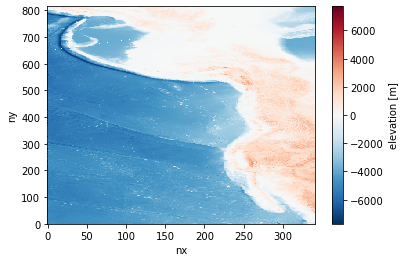

In [53]:
topo_out.elevation.plot()

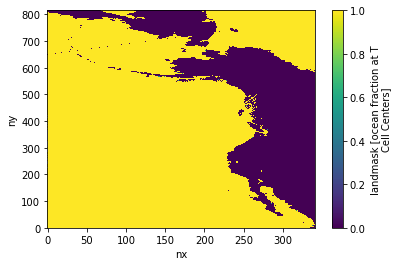

In [54]:
topo_out.landmask.plot()